In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
import pickle

In [1]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 8 * 1 + 3),
                             range=(0, 8 * 1 + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

In [5]:
data_dir = './CK+48/' 
classes = os.listdir(data_dir)
num_classes = len(classes)
X = []
y = []
input_size = (64, 64)

for label_index, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        
        if image is not None:
         # Preprocessing
            resized_image = cv2.resize(image, input_size)
            gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
            blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
            
            feature = extract_lbp_features(blurred_image)

            X.append(feature)
            y.append(label_index)

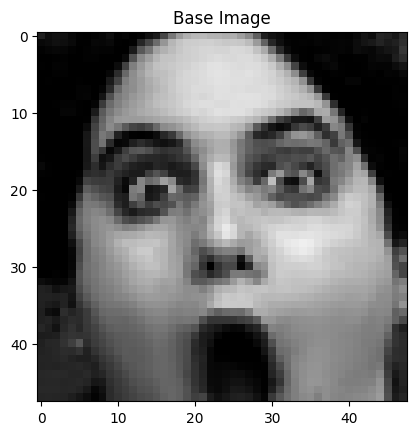

In [6]:
dummy_img = './CK+48/surprise/S124_001_00000014.png'
image = cv2.imread(dummy_img)
plt.imshow(image)
plt.title('Base Image')
plt.show()

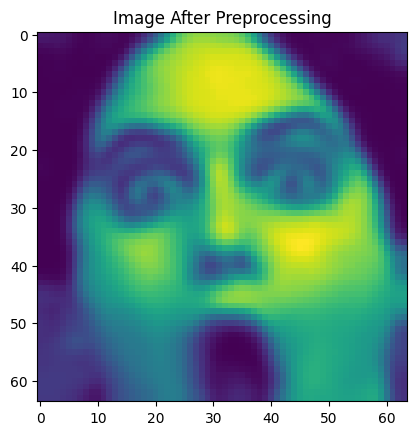

In [7]:
dummy_img = './CK+48/surprise/S124_001_00000014.png'
image = cv2.imread(dummy_img)
resized_image = cv2.resize(image, input_size)
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
plt.imshow(blurred_image)
plt.title('Image After Preprocessing')
plt.show()

In [8]:
x = np.array(X)
y = np.array(y)

In [9]:
# x = x.astype('float32')/255
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# from imblearn.over_sampling import SMOTE
# random = SMOTE(random_state=42)
# X_train, y_train = random.fit_resample(X_train, y_train)

In [12]:
model = RandomForestClassifier(n_estimators= 100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
y_pred = model.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}")

Accuracy: 52.79187817258884


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.44      0.52        27
           1       0.50      0.36      0.42        11
           2       0.50      0.69      0.58        35
           3       0.75      0.20      0.32        15
           4       0.49      0.60      0.54        42
           5       1.00      0.18      0.30        17
           6       0.52      0.66      0.58        50

    accuracy                           0.53       197
   macro avg       0.63      0.45      0.46       197
weighted avg       0.58      0.53      0.51       197



In [16]:
def preprocess_and_predict_lbp(image_path, model, scaler):
    # Baca gambar
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Gambar di {image_path} tidak ditemukan atau tidak valid.")
    
    # Preprocessing
    input_size = (64, 64)
    resized_image = cv2.resize(image, input_size)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Ekstraksi fitur LBP
    feature = extract_lbp_features(blurred_image)
    feature = np.array([feature])  # Ubah ke bentuk 2D (1, n_features)
    
    # Standarisasi
    feature_scaled = scaler.transform(feature)
    
    # Prediksi dengan model
    prediction = model.predict(feature_scaled)
    
    return prediction[0]  # Mengembalikan label prediksi

# Contoh penggunaan
image_path = './im2.png'
predicted_label = preprocess_and_predict_lbp(image_path, model, scaler)

print(f"Prediksi Kelas: {classes[predicted_label]}")

Prediksi Kelas: surprise


(-0.5, 63.5, 63.5, -0.5)

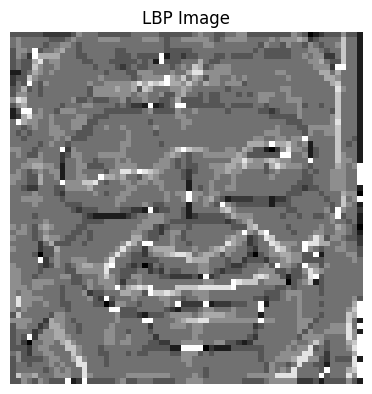

In [17]:
def extracts_lbp_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 8 * 1 + 3),
                             range=(0, 8 * 1 + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return lbp, hist

image = cv2.imread(image_path)
image = cv2.resize(image, (64,64))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.GaussianBlur(image, (5, 5), 0)

lbp_image, hist = extracts_lbp_features(image)
# Tampilkan LBP
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(lbp_image, cmap='gray')
plt.title('LBP Image')
plt.axis('off')


In [18]:
model_data = {
    'model_lbp': model,
    'scaler_lbp': scaler,
    'class_lbp': classes,
    'input_size_lbp': (64,64)
}

In [19]:
with open('LBP_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)